In [17]:
%matplotlib inline

In [147]:
import os
import numpy as np
import pickle as pkl
import pandas as pd

from matplotlib import pyplot as plt
from collections import defaultdict

from helpers import infected_nodes, cascade_source
from eval_helpers import get_scores_by_queries


In [3]:
graph = 'grqc-sto'
graph_suffix = '_rev'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_frac = "0.2"
cascade_fraction = "0.025"
obs_method = 'uniform'
cascade_model = 'ic'
dataset_id = '{}-m{}-s{}-o{}-om{}'.format(graph, cascade_model, cascade_fraction, obs_frac, obs_method)
cascade_dir = 'cascade-weighted/{}'.format(dataset_id)
fig_dirname = 'figs/inspect-query-process/{}'.format(dataset_id)

query_dir = 'outputs/queries-weighted/{}/{}/'.format(dataset_id, sampling_method)
probas_dir = 'outputs/inf_probas-weighted/{}/{}/'.format(dataset_id, sampling_method)
cascade_id = 0

if not os.path.exists(fig_dirname):
    os.makedirs(fig_dirname)

In [7]:
query_method = 'oracle-l'

In [12]:
obs, c = pkl.load(open('{}/{}.pkl'.format(cascade_dir, cascade_id), 'rb'))[:2]
inf_nodes = infected_nodes(c)
source = cascade_source(c)
print('cascade size', len(infected_nodes(c)))

cascade size 105


In [26]:
inf_probas = pkl.load(open(os.path.join(probas_dir, query_method, '0.pkl'), 'rb'))
qs, _ = pkl.load(open(os.path.join(query_dir, query_method, '0.pkl'), 'rb'))

In [84]:
score_list = defaultdict(list)


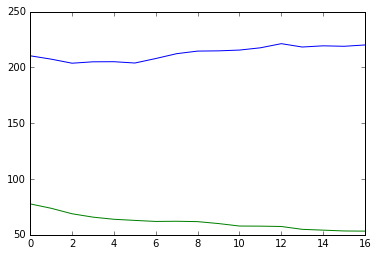

In [85]:
ax = plt.subplot()
eval_method = 'l1'
total_scores = {}

for eval_method in ['l1', 'l2']:
    def record_node_scores(scores):
        global score_list
        score_list[eval_method].append(scores) 
    scores = get_scores_by_queries(qs, inf_probas, c, obs, eval_method=eval_method,
                                   every=5,
                                   eval_with_mask=False,
                                   node_score_callback=record_node_scores)
    total_scores[eval_method] = scores
    ax.plot(scores)

In [86]:
l1, l2 = score_list['l1'], score_list['l2']

In [87]:
l1[0], l2[0]

(array([0.   , 0.057, 0.004, ..., 0.   , 0.027, 0.   ]),
 array([0.000e+00, 3.249e-03, 1.600e-05, ..., 0.000e+00, 7.290e-04,
        0.000e+00]))

In [88]:
pd.Series(l1[0]).describe()

count    4158.000000
mean        0.050601
std         0.126988
min         0.000000
25%         0.000000
50%         0.011000
75%         0.043000
max         1.000000
dtype: float64

In [89]:
pd.Series(l1[-1]).describe()

count    4158.000000
mean        0.052935
std         0.100086
min         0.000000
25%         0.000000
50%         0.014000
75%         0.055000
max         0.808000
dtype: float64

In [90]:
pd.Series(l2[0]).describe()

count    4158.000000
mean        0.018683
std         0.104051
min         0.000000
25%         0.000000
50%         0.000121
75%         0.001849
max         1.000000
dtype: float64

In [91]:
pd.Series(l2[-1]).describe()

count    4158.000000
mean        0.012817
std         0.047672
min         0.000000
25%         0.000000
50%         0.000196
75%         0.003025
max         0.652864
dtype: float64

(array([3949., 4051., 4088., 4113., 4135., 4143., 4151., 4154., 4156.,
        4158.]),
 array([0.       , 0.0652864, 0.1305728, 0.1958592, 0.2611456, 0.326432 ,
        0.3917184, 0.4570048, 0.5222912, 0.5875776, 0.652864 ]),
 <a list of 10 Patch objects>)

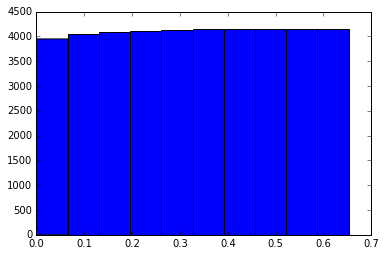

In [92]:
plt.hist(l2[-1], cumulative=True)

(array([3334., 3783., 3936., 4006., 4069., 4101., 4134., 4149., 4154.,
        4158.]),
 array([0.    , 0.0808, 0.1616, 0.2424, 0.3232, 0.404 , 0.4848, 0.5656,
        0.6464, 0.7272, 0.808 ]),
 <a list of 10 Patch objects>)

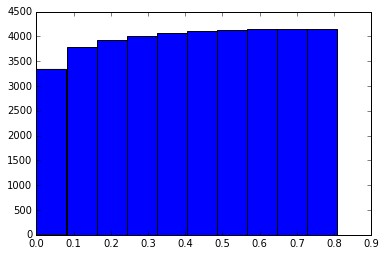

In [93]:
plt.hist(l1[-1], cumulative=True)

In [94]:
l1[2:4]

[array([0.   , 0.059, 0.003, ..., 0.   , 0.028, 0.   ]),
 array([0.   , 0.058, 0.002, ..., 0.   , 0.035, 0.   ])]

In [95]:
for k in range(10):
    l11, l12 = total_scores['l1'][k:k+2]
    l21, l22 = total_scores['l2'][k:k+2]
    if l11 < l12 and l21> l22:
        print(k)
        print(l11, l12)
        print(l21, l22)
        break

2
203.75400000000002 205.019
68.853498 65.823985


In [96]:
l11, l12 = l1[k], l1[k+1]
l21, l22 = l2[k], l2[k+1]

In [102]:
d1 = (l12 - l11)

In [103]:
d2 = (l22 - l21)

In [127]:
# pos/neg means we are improving/degrading the prediction

d1_neg, d1_pos = d1[d1 > 0], d1[d1 < 0]
d2_neg, d2_pos = d2[d2 > 0], d2[d2 < 0]

In [119]:
assert d1_neg.shape == d2_neg.shape
assert d1_pos.shape == d2_pos.shape

In [138]:
d1_pos[d1_pos != -1].min(), d2_pos[d2_pos != 0].max()

(-0.946, -1e-06)

In [133]:
print('d1 pos/neg: ', d1_pos.sum(), d1_neg.sum())
print('d2 pos/neg: ', d2_pos.sum(), d2_neg.sum())

d1 pos/neg:  -11.622 12.887
d2 pos/neg:  -6.28328 3.253767


In [225]:
columns = ('l1(k=0)', 'l2(k=0)', 'l1(k=-1)', 'l2(k=1)')
for k in [1, 2, 3, 4, 5, -1]:
    df = pd.DataFrame(list(zip(l1[0], l2[0], l1[k], l2[k])), columns=columns)
    df = df[df['l1(k=0)'] > 0]
    print('k=', k)
    # number of nodes that have better prediction
    print('num. positively learned vertices', df[df['l1(k=0)'] >= df['l1(k=-1)']].shape[0])
    # number of nodes that have worse prediction
    print('num. negatively learned vertices', df[df['l1(k=0)'] < df['l1(k=-1)']].shape[0])
    print('')

k= 1
num. positively learned vertices 1369
num. negatively learned vertices 1267

k= 2
num. positively learned vertices 1288
num. negatively learned vertices 1348

k= 3
num. positively learned vertices 1154
num. negatively learned vertices 1482

k= 4
num. positively learned vertices 1067
num. negatively learned vertices 1569

k= 5
num. positively learned vertices 1067
num. negatively learned vertices 1569

k= -1
num. positively learned vertices 433
num. negatively learned vertices 2203



In [217]:
d1 = l1[1] - l1[0]

In [218]:
final_obs = set(obs) | set(qs)

In [219]:
pos_learned_nodes = set(np.nonzero(d1 < 0)[0])
neg_learned_nodes = set(np.nonzero(d1 > 0)[0])

In [220]:
len(pos_learned_nodes), len(neg_learned_nodes)

(1196, 1277)

In [215]:
len(set(inf_nodes) & pos_learned_nodes)

78